# Visualize Input Features 
### This notebook visualizes the input features of the clothing transfer model used in SmartFit

### Usage: To replicate the results of this notebook, run the cells after setting up the repository and running the test example as defined in the README.

In [23]:
import numpy as np
import pickle as pkl
import scipy.io
from scipy import misc
from matplotlib import pyplot as plt
import imageio

from skimage import data
from skimage.transform import resize

## 0) Input image

In [24]:
# pic = misc.imread('../inputs/example_person.jpg')
pic = imageio.imread('../inputs/example_person.jpg')

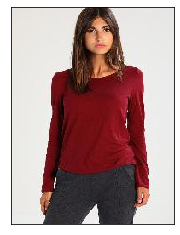

In [25]:
plt.imshow(pic)
plt.xticks([])
plt.yticks([])
plt.show()

## 1) Body mask from the human parsing model

```
Segmentation Mapping (i.e. pixel values)
0 Background, 1 Hat, 2 Hair, 3 Glove, 4 Sunglasses, 5 Upper-clothes
6 Dress, 7 Coat, 8 Socks, 9 Pants, 10 Jumpsuits, 11 Scarf
12 Skirt, 13 Face, 14 Left-arm, 15 Right-arm, 16 Left-leg, 17 Right-leg
 ```

In [26]:
img = scipy.io.loadmat('../human_parsing/output/example_person.mat')
img = img['segment']

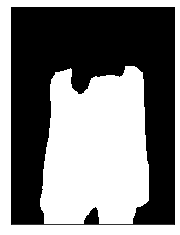

In [27]:
# Keep all pixels but face/hair-related items
plt.imshow(((img!=1)&(img!=2)&(img!=4)&(img!=13)&(img!=0)), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## 2) Face and pants extraction

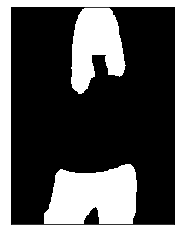

In [28]:
# Keep face/hair-related items and pants
mask = ((img==1)|(img==2)|(img==4)|(img==13)|(img==9))

plt.imshow(mask, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [29]:
# Resize in case using an image of different dimension than 256 x 192
pic = resize(pic, (256, 192))

In [30]:
# Stack mask into a 3-channel image so that it can be applied to RGB images
masked_img = pic*np.stack([mask]*3, axis=2)

In [31]:
# Set background to white
masked_img[masked_img==0] = 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


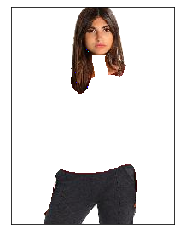

In [32]:
# Plot image
plt.imshow(masked_img)
plt.xticks([])
plt.yticks([])
plt.show()

## 3) Keypoint map from the pose estimation model

```
Pose numbering correspondence
0 Nose, 1 Neck, 2 Right-shoulder, 3 Right-elbow, 4 RWrist, 5 LShoulder, 6 Left-elbow
7 Left-wrist, 8 Right-hip, 9 Right-knee, 10 Right-ankle, 11 Left-hip, 12 Left-knee 
13 Left-ankle, 14 Right-eye, 15 Left-eye, 16 Right-ear, 17 Left-ear, 18 Background
```

In [33]:
# Reads pose dictionary and returns array of keypoints
# Modified from https://github.com/xthan/VITON/blob/master/prepare_data/build_viton.py
def _extract_pose_keypoints(pose):
  pose_keypoints = - np.ones((18,2), dtype=int)
  for i in range(18):
    if pose['subset'][0,i] != -1: # If keypoint exists
      pose_keypoints[i,:] = pose['candidate'][int(pose['subset'][0,i]),:2]
  return pose_keypoints # only return the coordinates

In [34]:
# Returns image with 5x5 squares around keypoints
# Takes as inputs the pose keypoints and original image height and widtha
# Modified from https://github.com/xthan/VITON/blob/master/prepare_data/build_viton.py 
def _extract_pose_map(pose_keypoints, h, w):
    resize_h = 256.0
    resize_w = 192.0
    pose_keypoints = np.asarray(pose_keypoints, np.float32)
    pose_keypoints[:, 0] = pose_keypoints[:, 0] * resize_w / float(w)
    pose_keypoints[:, 1] = pose_keypoints[:, 1] * resize_h / float(h)
    pose_keypoints = np.asarray(pose_keypoints, np.int)

    pose_map = np.zeros((int(resize_h),int(resize_w),18))
    for i in range(18):
        if pose_keypoints[i,0] < 0:
            continue
        t = np.max((pose_keypoints[i,1] - 5, 0))
        b = np.min((pose_keypoints[i,1] + 5, h - 1))
        l = np.max((pose_keypoints[i,0] - 5, 0))
        r = np.min((pose_keypoints[i,0] + 5, w - 1))
        pose_map[t:b+1, l:r+1, i] = 255
    return pose_map

In [35]:
pose_dict = pkl.load(open('../try-on/VITON/data/pose.pkl','rb'))

In [36]:
# Extract keypoints
pose_map = _extract_pose_keypoints(pose_dict['example_person'])

In [37]:
# Returns an 18-channel image (one for each keypoint). Reduce to 1-channel image for visualization
pose_img = _extract_pose_map(pose_map, img.shape[0], img.shape[1])
pose_img = np.sum(pose_img, axis=2)

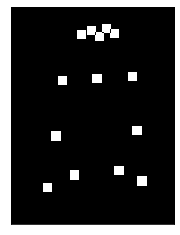

In [38]:
plt.imshow((pose_img==255), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## 4) Clothing Item

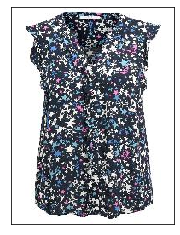

In [39]:
top = imageio.imread('../inputs/example_clothing.jpg')
plt.imshow(top)
plt.xticks([])
plt.yticks([])
plt.show()